# Regression with MultiMIL

In this tutorial, we demonstrate how to train MultiMIL on the latent representation of an atlas. We will use the human lung cell atlas (HLCA) {cite:p}`Sikkema2023-oh`, subset to healthy and idiopathic pulmonary fibrosis (IPF) samples.

We recommend the users always train MultiMIL on batch-corrected low-dimensional representations of the data.

The model will be trained to predict age. We will obtain cell attention scores that are associated with age. We envision that the regression setting could be useful when the users are interested in disease progression, i.e. different disease stages. It also can be beneficial to run the ordinal regression setting in this case that is described in [this tutorial](https://multimil.readthedocs.io/en/latest/notebooks/mil_classification.html).

We also recommend the users to check out our [sample-prediction pipeline](https://github.com/theislab/sample-prediction-pipeline), which includes MultiMIL and several other baselines, to assess whether the multiple-instance learning (MIL) approach is necessary for your use case or if pseudo-bulking or looking at cell type frequencies is sufficient to differentiate between stages.

In [1]:
import sys

# if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install multimil
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/multimil

In [2]:
import multimil as mtm
import numpy as np
import scanpy as sc
import pandas as pd
import scvi
import warnings
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil_bioarxiv/lib/python3.10/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
Global seed set to 0


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 0.20.3


## Data loading

We will subset the HLCA to healthy samples for which the age information is available. The data already contains the latent representations from the atlas.

In [4]:
data_path = "hlca_tutorial.h5ad"

In [5]:
try:
    adata = sc.read_h5ad(data_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1wWGwbPeap-IqWNVlwVVUWVrUAMrf45ye")
    adata = sc.read_h5ad(data_path)

adata

AnnData object with n_obs × n_vars = 450214 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final'
    obsm: 'X_umap'

## Data preparation

We will split the data into 3 cross-validation splits and check the prediction performance on the validation set to make sure that the model generalizes, which in turn means that the learned cell attention scores are also reflective of the covariate of interest.

Depending on how big your dataset is, i.e. how many samples there are, you might want to have 3 to 5 splits, but make sure that there is at least a few samples from each class in each of the validation splits so the prediction performance on the validation set can be assessed properly.

We will first walk through the steps required to train the model on one of the splits, and then we'll repeat the steps for the other two splits before looking into detail at the cell attention scores.

In [6]:
sample_key = "sample"  # the smallest sample-level grouping variable, could be e.g. patient or sample (not batch)
condition_key = (
    "age_or_mean_of_age_range"  # column containing condition labels, has to be the same value for all cells in a sample
)

In [7]:
adata = adata[~adata.obs[condition_key].isna()].copy()
adata.obs["disease"].value_counts()

disease
normal    171706
Name: count, dtype: int64

In [8]:
samples = np.array(adata.obs[sample_key].unique())
len(samples)

56

In [9]:
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

for i, (train_index, val_index) in enumerate(kf.split(samples)):
    train_samples = samples[train_index]
    val_samples = samples[val_index]
    adata.obs.loc[adata.obs[sample_key].isin(train_samples), f"split{i}"] = "train"
    adata.obs.loc[adata.obs[sample_key].isin(val_samples), f"split{i}"] = "val"

In [10]:
query = adata[adata.obs["split1"] == "val"].copy()
ref = adata[adata.obs["split1"] == "train"].copy()

query.obs["ref"] = "query"
ref.obs["ref"] = "reference"

In [11]:
query

AnnData object with n_obs × n_vars = 33142 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final', 'split0', 'split1', 'split2', 'ref'
    obsm: 'X_umap'

## Data setup

We need to specify which covariate will be our prediction covariate, so in this case it is `age_or_mean_of_age_range`. The sample key is needed so the model knows which cells come from which sample.

In [12]:
regression_keys = [condition_key]
categorical_covariate_keys = [sample_key]
continuous_covariate_keys = regression_keys

For the training to work properly, we need to sort the data by samples.

In [13]:
idx = ref.obs[sample_key].sort_values().index
ref = ref[idx].copy()

idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

In [14]:
mtm.model.MILClassifier.setup_anndata(
    ref,
    categorical_covariate_keys=categorical_covariate_keys,
    continuous_covariate_keys=continuous_covariate_keys,
)

## Model setup and training

Next, we initialize the model. We need to specify the prediction covariate and the sample key.  The prediction covariate and the sample key have to be registered covariates that we passed to `setup_anndata()` in the previous step. We set the coefficient for the classification (i.e. regression) loss here to 0.1. This parameter might require some fine-tuning depending on the dataset.

In [15]:
mil = mtm.model.MILClassifier(
    ref,
    regression=regression_keys,
    sample_key=sample_key,
    class_loss_coef=0.1,
)

In [16]:
mil.train(max_epochs=20)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [01:20<00:00,  3.56s/it, loss=16.8, v_num=1]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:20<00:00,  4.03s/it, loss=16.8, v_num=1]


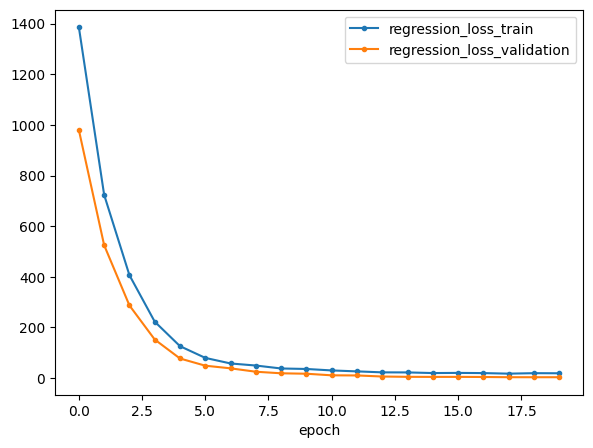

In [17]:
mil.plot_losses()

Next, we obtain the learned attention scores; they are saved to `.obs['cell_attn']` by default.

In [18]:
mil.get_model_output()
ref

AnnData object with n_obs × n_vars = 138564 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final', 'split0', 'split1', 'split2', 'ref', '_scvi_batch', 'cell_attn', 'bags', 'predicted_age_or_mean_of_age_range'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'bag_true_age_or_mean_of_age_range', 'bag_full_predictio

## Predicting on the query samples

In [19]:
new_model = mtm.model.MILClassifier.load_query_data(query, mil)

In [20]:
new_model.get_model_output()
query

AnnData object with n_obs × n_vars = 33142 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final', 'split0', 'split1', 'split2', 'ref', '_scvi_batch', 'cell_attn', 'bags', 'predicted_age_or_mean_of_age_range'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'bag_true_age_or_mean_of_age_range', 'bag_full_prediction

To be able to access the cell attention scores after the training for the other two splits, we also save them in `.obs['cell_attn_0']` in the original `adata` object.

In [21]:
cell_attn_0 = pd.concat([ref.obs["cell_attn"], query.obs["cell_attn"]])
cell_attn_0.name = "cell_attn_0"

In [22]:
adata.obs = adata.obs.join(cell_attn_0)

We can also calculate the r2 for the query samples. Here, we calculate it on the cell level, where the prediction for each cell was copied over from the sample prediction. It's only possible to calculate the prediction on the bag level by accessing the bag prediction stored in `query.uns['full_predictions_age_or_mean_of_age_range']`.

In [23]:
query

AnnData object with n_obs × n_vars = 33142 × 30
    obs: "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ancestry', 'assay', 'cause_of_death', 'cell_type', 'core_or_extension', 'dataset', 'development_stage', 'disease', 'donor_id', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'sample', 'scanvi_label', 'sequencing_platform', 'sex', 'smoking_status', 'study', 'subject_type', 'suspension_type', 'tissue', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'total_counts', 'ann_level_1_label_final', 'ann_level_2_label_final', 'ann_level_3_label_final', 'ann_level_4_label_final', 'ann_level_5_label_final', 'split0', 'split1', 'split2', 'ref', '_scvi_batch', 'cell_attn', 'bags', 'predicted_age_or_mean_of_age_range'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'bag_true_age_or_mean_of_age_range', 'bag_full_prediction

In [24]:
from sklearn.metrics import r2_score

r2_score(query.obs[condition_key], query.obs[f"predicted_{condition_key}"])

0.013740765070872074

## Putting all together for the rest of the splits

Next, we perform the training for the other two splits. We recommend the users to use the code snippet from the following cell and run it for all the splits in their analysis.

In [25]:
for i in range(1, n_splits):  # change to range(n_splits) to run all splits
    print(f"Processing split {i}...")
    query = adata[adata.obs[f"split{i}"] == "val"].copy()
    ref = adata[adata.obs[f"split{i}"] == "train"].copy()

    query.obs["ref"] = "query"
    ref.obs["ref"] = "reference"

    idx = ref.obs[sample_key].sort_values().index
    ref = ref[idx].copy()

    idx = query.obs[sample_key].sort_values().index
    query = query[idx].copy()

    mtm.model.MILClassifier.setup_anndata(
        ref,
        categorical_covariate_keys=categorical_covariate_keys,
        continuous_covariate_keys=continuous_covariate_keys,
    )

    mil = mtm.model.MILClassifier(
        ref,
        regression=regression_keys,
        sample_key=sample_key,
        class_loss_coef=0.1,
    )

    mil.train(max_epochs=20)

    mil.get_model_output()

    new_model = mtm.model.MILClassifier.load_query_data(query, mil)

    new_model.get_model_output()

    cell_attn_i = pd.concat([ref.obs["cell_attn"], query.obs["cell_attn"]])
    cell_attn_i.name = f"cell_attn_{i}"

    adata.obs = adata.obs.join(cell_attn_i)

    print(r2_score(query.obs[condition_key], query.obs[f"predicted_{condition_key}"]))

Processing split 1...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [01:04<00:00,  3.29s/it, loss=17.7, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:04<00:00,  3.21s/it, loss=17.7, v_num=1]
0.2184988529988917
Processing split 2...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|██████████| 20/20 [00:46<00:00,  2.37s/it, loss=31.7, v_num=1]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:46<00:00,  2.35s/it, loss=31.7, v_num=1]
0.2793189454292896


## Cell attention scores and sample representations

We check the consistency of the attention scores per split and use the averaged scores for downstream analysis and sample representation calculation.

In [26]:
adata.obs["cell_attn"] = np.mean(adata.obs[["cell_attn_0", "cell_attn_1", "cell_attn_2"]].values, axis=1)

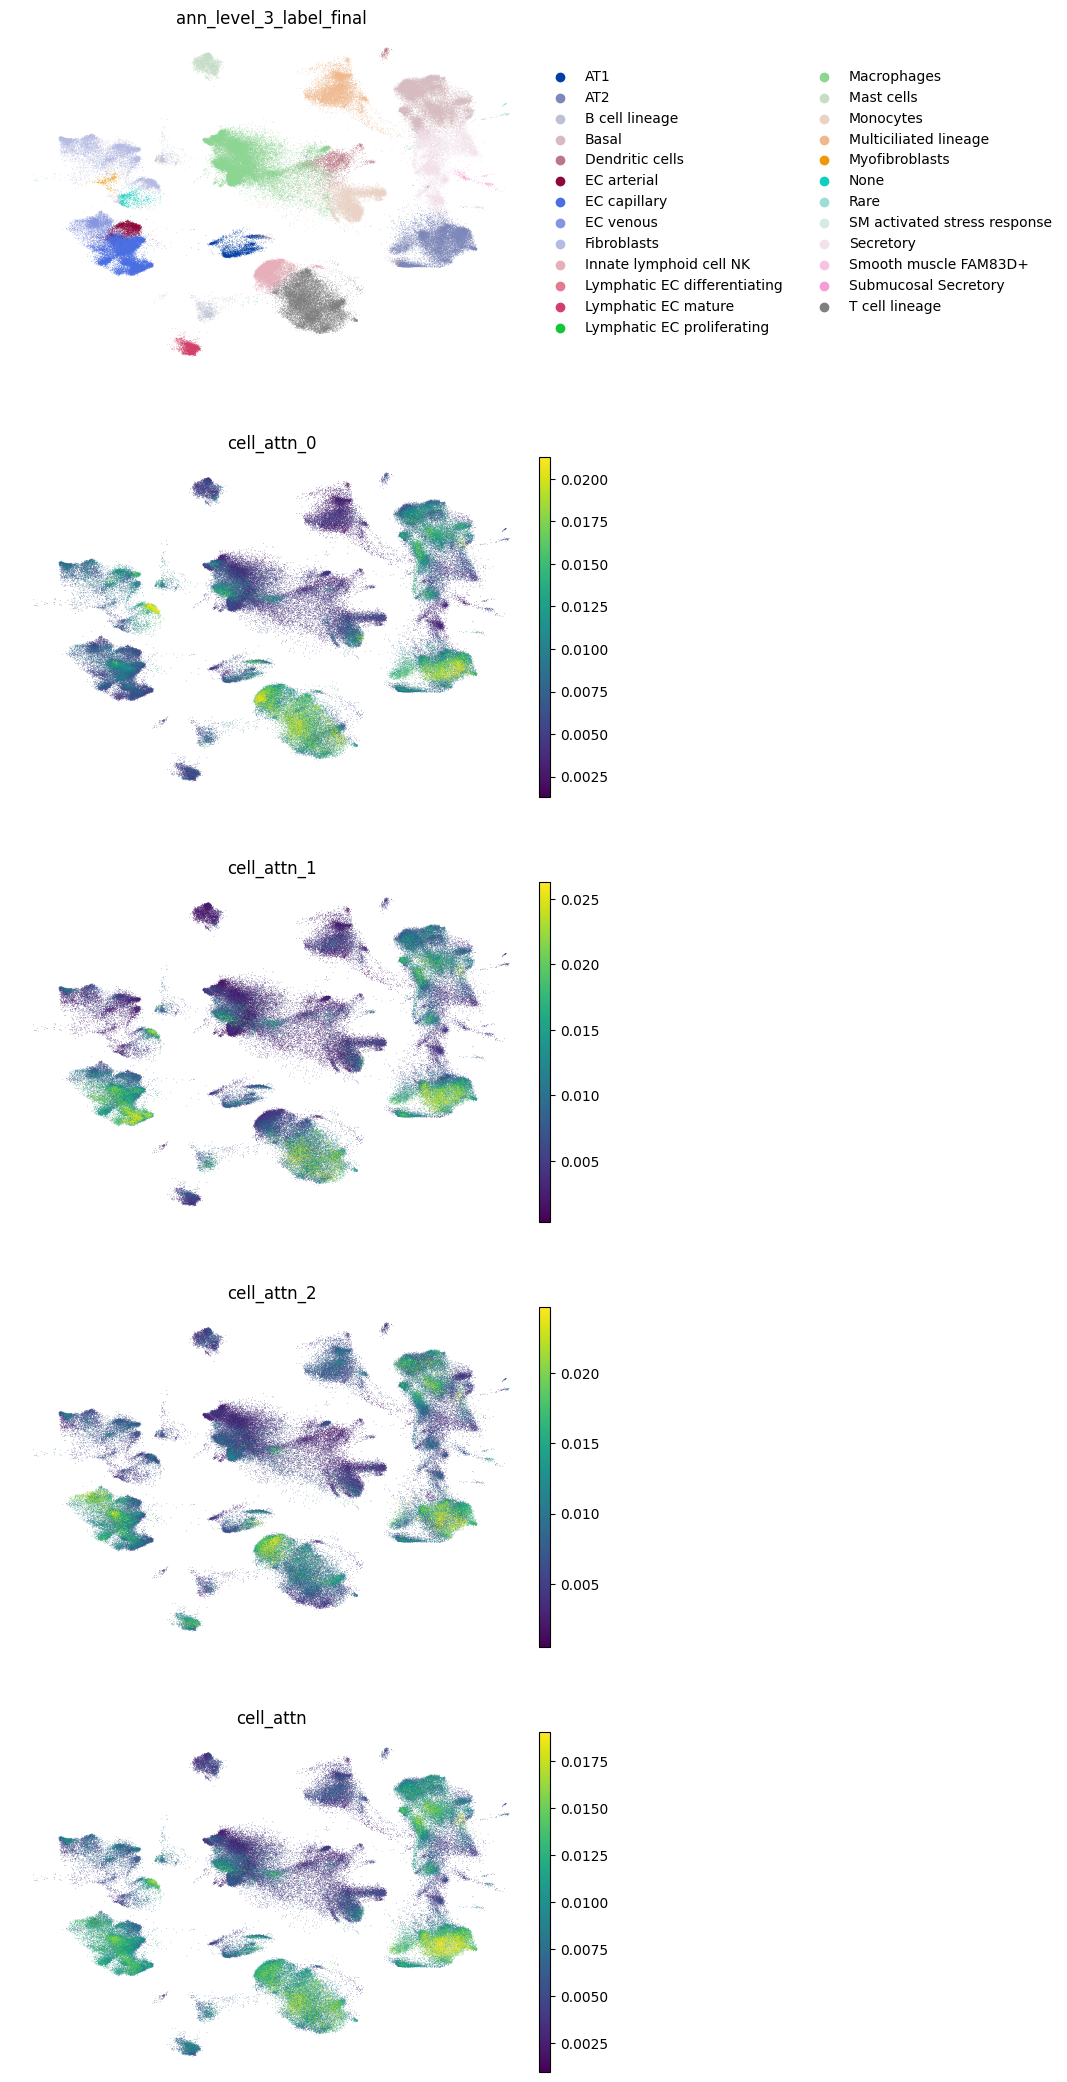

In [27]:
sc.pl.umap(
    adata,
    color=["ann_level_3_label_final", "cell_attn_0", "cell_attn_1", "cell_attn_2", "cell_attn"],
    ncols=1,
    frameon=False,
    vmax="p99",
)

Next, we identify cells with high attention scores (top 10%) and save this information into a new column to `.obs`. These cells are most associated with age. We recommend using the cells with high attention for downstream analyses.

In [28]:
mtm.utils.score_top_cells(adata)  # uses .obs['cell_attn'] by default

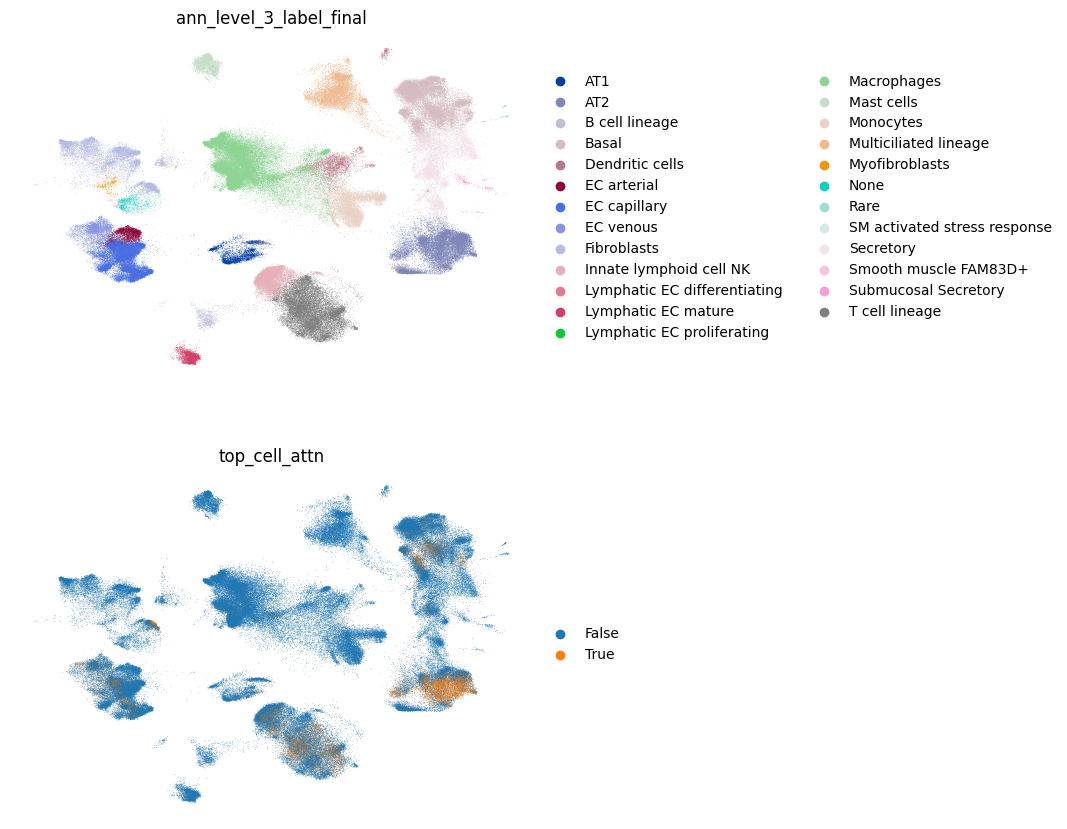

In [29]:
sc.pl.umap(
    adata,
    color=["ann_level_3_label_final", "top_cell_attn"],
    ncols=1,
    frameon=False,
)

Finally, we use the cell attention scores to calculate the sample representations as a weighted sum of cell representations for each sample.

In [30]:
sample_reps = mtm.utils.get_sample_representations(adata, sample_key=sample_key, covs_to_keep=[condition_key])
sample_reps

AnnData object with n_obs × n_vars = 56 × 30
    obs: 'age_or_mean_of_age_range'

In [31]:
sc.pp.neighbors(sample_reps, n_neighbors=10)
sc.tl.umap(sample_reps)

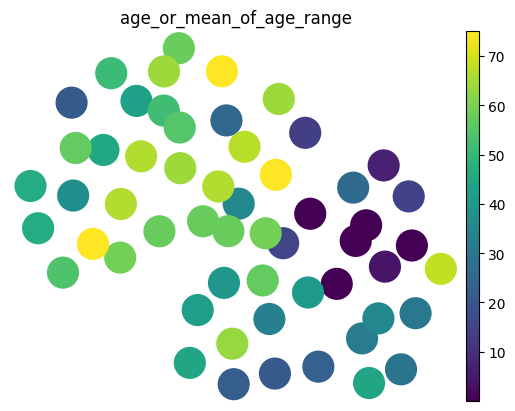

In [32]:
sc.pl.umap(
    sample_reps,
    color=[condition_key],
    ncols=1,
    frameon=False,
)